In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,36398,None,None,85829.241622
2020-06-13,36399,None,None,79740.807871
2020-06-14,36400,None,None,74085.775579
2020-06-15,36401,None,None,68758.947317
2020-06-16,36402,None,None,64014.165255
...,...,...,...,...
2021-03-03,36662,None,None,137319.476592
2021-03-04,36663,None,None,134460.014190
2021-03-05,36664,None,None,131263.425193


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-07_2021-03-07-17-58.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-06_2021-03-06-18-00.pickle


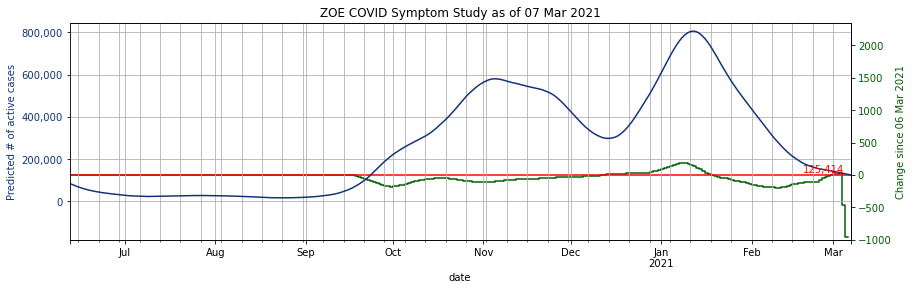

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

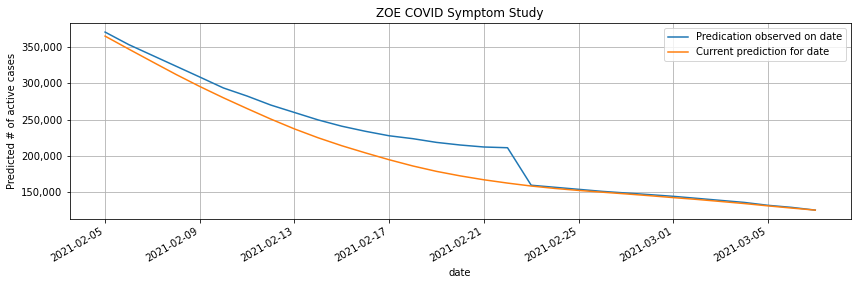

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-03-07_2021-03-07-17-58.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
244,Nuneaton and Bedworth,E07000219,2.771929
297,Falkirk,S12000014,1.581290
189,West Lindsey,E07000142,1.513730
180,Cannock Chase,E07000192,1.285548
205,Ashfield,E07000170,1.196183
326,Isle of Anglesey,W06000001,1.185919
266,Bolton,E08000001,1.184234
16,East Riding of Yorkshire,E06000011,1.104703
377,Stirling,S12000030,1.094212
232,Welwyn Hatfield,E07000241,0.870648
